In [ ]:
from __future__ import absolute_import, division, print_function, unicode_literals

try:
  # %tensorflow_version only exists in Colab.
  !pip install tf-nightly-gpu-2.0-preview
except Exception:
  pass
import tensorflow as tf

import os
import time
import matplotlib.pyplot as plt
from IPython.display import clear_output


In [ ]:
from zipfile import ZipFile

file_name = "train.zip"
with ZipFile(file_name, 'r') as zip_1:
  zip_1.extractall()
  print('Done')
  
file_name = "test.zip"
with ZipFile(file_name, 'r') as zip_1:
  zip_1.extractall()
  print('Done')
  


Done
Done


In [ ]:
BUFFER_SIZE = 2000
BATCH_SIZE = 1 #stochastic gradient descent
IMG_WIDTH = 256
IMG_HEIGHT = 256

In [ ]:
PATH = '/content/'
def load(image_file):
  image = tf.io.read_file(image_file)
  image = tf.image.decode_jpeg(image)

  w = tf.shape(image)[1]

  w = w // 2
  real_image = image[:, :w, :]
  input_image = image[:, w:, :]

  input_image = tf.cast(input_image, tf.float32)
  real_image = tf.cast(real_image, tf.float32)

  return input_image, real_image

/content/


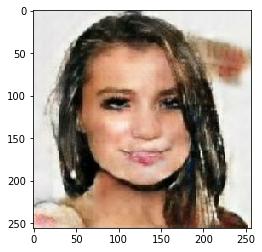

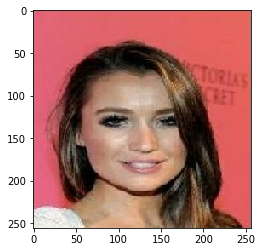

In [ ]:
inp, re = load(PATH+'train/1000.jpg')
print(PATH)
# casting to int for matplotlib to show the image
plt.figure()
plt.imshow(inp/255.0)
plt.figure()
plt.imshow(re/255.0)

In [ ]:
def resize(input_image, real_image, height, width):
  input_image = tf.image.resize(input_image, [height, width],
                                method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  real_image = tf.image.resize(real_image, [height, width],
                               method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

  return input_image, real_image

In [ ]:
# normalizing the images to [-1, 1]

def normalize(input_image, real_image):
  input_image = (input_image / 127.5) - 1
  real_image = (real_image / 127.5) - 1

  return input_image, real_image

In [ ]:
def load_image_train(image_file):
  input_image, real_image = load(image_file)
  #input_image, real_image = random_jitter(input_image, real_image)
  input_image, real_image = normalize(input_image, real_image)

  return input_image, real_image

In [ ]:
def load_image_test(image_file):
  input_image, real_image = load(image_file)
  input_image, real_image = resize(input_image, real_image,
                                   IMG_HEIGHT, IMG_WIDTH)
  input_image, real_image = normalize(input_image, real_image)

  return input_image, real_image

In [ ]:
train_dataset = tf.data.Dataset.list_files(PATH+'train/*.jpg')
train_dataset = train_dataset.map(load_image_train,
                                  num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_dataset = train_dataset.cache().shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(1)

sample_data = next(iter(train_dataset))
tf.shape(sample_data[0][0])



<tf.Tensor: shape=(3,), dtype=int32, numpy=array([256, 256,   3], dtype=int32)>

In [ ]:
test_dataset = tf.data.Dataset.list_files(PATH+'test/*.jpg')
test_dataset = test_dataset.map(load_image_test)
test_dataset = test_dataset.batch(1)

In [ ]:
OUTPUT_CHANNELS = 3

In [ ]:
def downsample(filters, size, apply_batchnorm=True):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

  if apply_batchnorm:
    result.add(tf.keras.layers.BatchNormalization())

  result.add(tf.keras.layers.LeakyReLU())

  return result

In [ ]:
down_model = downsample(3, 4)
down_result = down_model(tf.expand_dims(inp, 0))
print (down_result.shape)

(1, 128, 128, 3)


In [ ]:
def upsample(filters, size, apply_dropout=False):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
    tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False))

  result.add(tf.keras.layers.BatchNormalization())

  if apply_dropout:
      result.add(tf.keras.layers.Dropout(0.5))

  result.add(tf.keras.layers.ReLU())

  return result

In [ ]:
up_model = upsample(3, 4)
up_result = up_model(down_result)
print (up_result.shape)

(1, 256, 256, 3)


In [ ]:
def Generator():
  down_stack = [
    downsample(64, 4),
    downsample(64, 4), 
    downsample(128, 4), 
    downsample(128, 4), 
    downsample(256, 4),
    downsample(256, 4), 
    downsample(512, 4), 
    downsample(512, 4),
  ]

  up_stack = [
    upsample(512, 4, apply_dropout=True), 
    upsample(256, 4, apply_dropout=True),
    upsample(256, 4, apply_dropout=True), 
    upsample(128, 4), 
    upsample(128, 4),
    upsample(64, 4), 
    upsample(64, 4),
  ]

  initializer = tf.random_normal_initializer(0., 0.02)
  last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                         strides=2,
                                         padding='same',
                                         kernel_initializer=initializer,
                                         activation='tanh') # (bs, 256, 256, 3)

  concat = tf.keras.layers.Concatenate()

  inputs = tf.keras.layers.Input(shape=[None,None,3])
  x = inputs

  # Downsampling through the model
  skips = []
  for down in down_stack:
    x = down(x)
    skips.append(x)

  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    x = concat([x, skip])

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


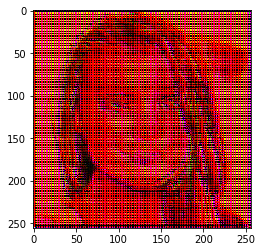

In [ ]:
generator = Generator()

gen_output = generator(inp[tf.newaxis,...], training=False)
plt.imshow(gen_output[0,...])

In [ ]:
def Discriminator():
  initializer = tf.random_normal_initializer(0., 0.02)

  inp = tf.keras.layers.Input(shape=[None, None, 3], name='input_image')
  tar = tf.keras.layers.Input(shape=[None, None, 3], name='target_image')

  x = tf.keras.layers.concatenate([inp, tar]) 

  down1 = downsample(64, 4, False)(x) 
  down2 = downsample(128, 4)(down1)
  down3 = downsample(256, 4)(down2)

  zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3)
  conv = tf.keras.layers.Conv2D(512, 4, strides=1,
                                kernel_initializer=initializer,
                                use_bias=False)(zero_pad1)

  batchnorm1 = tf.keras.layers.BatchNormalization()(conv)

  leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)

  zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu)

  last = tf.keras.layers.Conv2D(1, 4, strides=1,
                                kernel_initializer=initializer)(zero_pad2)

  return tf.keras.Model(inputs=[inp, tar], outputs=last)

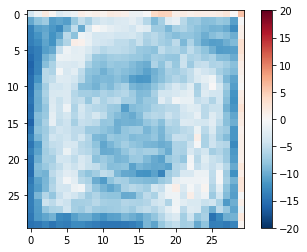

In [ ]:
discriminator = Discriminator()
disc_out = discriminator([inp[tf.newaxis,...], gen_output], training=False)
plt.imshow(disc_out[0,...,-1], vmin=-20, vmax=20, cmap='RdBu_r')
plt.colorbar()

In [ ]:
LAMBDA = 100

In [ ]:
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [ ]:
def discriminator_loss(disc_real_output, disc_generated_output):
  
  total_disc_loss = tf.reduce_sum(tf.square(disc_real_output-1) + tf.square(disc_generated_output))/2

  return total_disc_loss

In [ ]:
def generator_loss(disc_generated_output, gen_output, target):
  
  gen_loss = tf.reduce_sum(tf.square(disc_generated_output-1))/2

  return gen_loss

In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [ ]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [ ]:
EPOCHS = 150

In [ ]:
def generate_images(model, test_input, tar):
  # the training=True is intentional here since
  # we want the batch statistics while running the model
  # on the test dataset. If we use training=False, we will get
  # the accumulated statistics learned from the training dataset
  # (which we don't want)
  prediction = model(test_input, training=True)
  plt.figure(figsize=(15,15))

  display_list = [test_input[0], tar[0], prediction[0]]
  title = ['Input Image', 'Ground Truth', 'Predicted Image']

  for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.title(title[i])
    # getting the pixel values between [0, 1] to plot it.
    plt.imshow(display_list[i] * 0.5 + 0.5)
    plt.axis('off')
  plt.savefig('result.png',bbox_inches='tight')
  #files.download("result.png") 
  print('done')
  plt.show()

In [ ]:
@tf.function
def train_step(input_image, target):
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    gen_output = generator(input_image, training=True)

    disc_real_output = discriminator([input_image, target], training=True)
    disc_generated_output = discriminator([input_image, gen_output], training=True)

    gen_loss = generator_loss(disc_generated_output, gen_output, target)
    disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

  generator_gradients = gen_tape.gradient(gen_loss,
                                          generator.trainable_variables)
  discriminator_gradients = disc_tape.gradient(disc_loss,
                                               discriminator.trainable_variables)

  generator_optimizer.apply_gradients(zip(generator_gradients,
                                          generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                              discriminator.trainable_variables))

In [ ]:
def fit(train_ds, epochs, test_ds):
  for epoch in range(epochs):
    start = time.time()

    # Train
    for input_image, target in train_ds:
      train_step(input_image, target)

    clear_output(wait=True)
    # Test on the same image so that the progress of the model can be 
    # easily seen.
    for example_input, example_target in test_ds.take(1):
      generate_images(generator, example_input, example_target)

    # saving (checkpoint) the model every 20 epochs
    if (epoch + 1) % 20 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1,
                                                        time.time()-start))

In [ ]:
fit(train_dataset, EPOCHS, test_dataset)#########################

done
Buffered data was truncated after reaching the output size limit.

In [ ]:
!ls {checkpoint_dir}

checkpoint		    ckpt-4.data-00001-of-00002
ckpt-1.data-00000-of-00002  ckpt-4.index
ckpt-1.data-00001-of-00002  ckpt-5.data-00000-of-00002
ckpt-1.index		    ckpt-5.data-00001-of-00002
ckpt-2.data-00000-of-00002  ckpt-5.index
ckpt-2.data-00001-of-00002  ckpt-6.data-00000-of-00002
ckpt-2.index		    ckpt-6.data-00001-of-00002
ckpt-3.data-00000-of-00002  ckpt-6.index
ckpt-3.data-00001-of-00002  ckpt-7.data-00000-of-00002
ckpt-3.index		    ckpt-7.data-00001-of-00002
ckpt-4.data-00000-of-00002  ckpt-7.index


In [ ]:
# restoring the latest checkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint("/content/training_checkpoints/"))

done


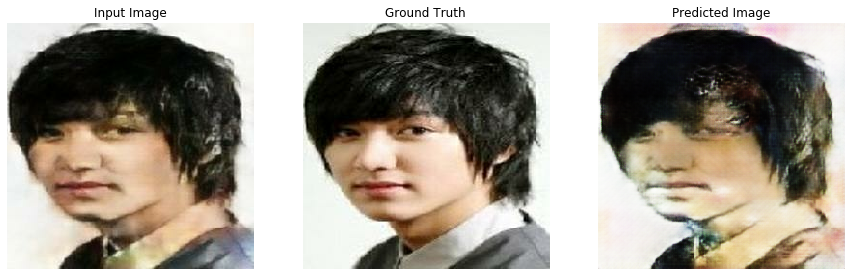

done


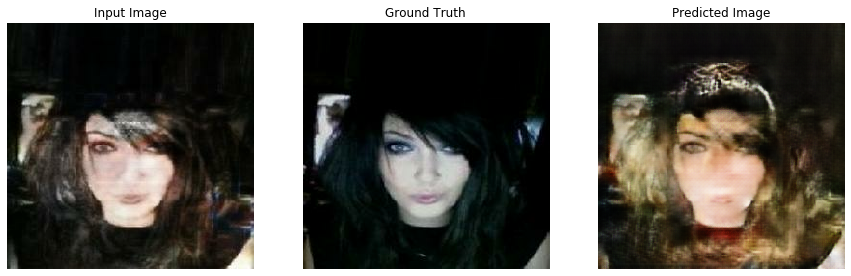

done


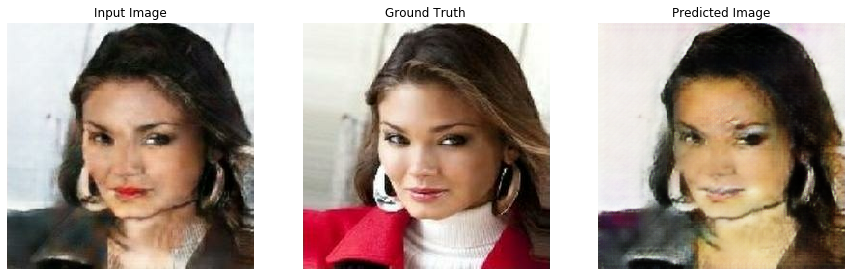

done


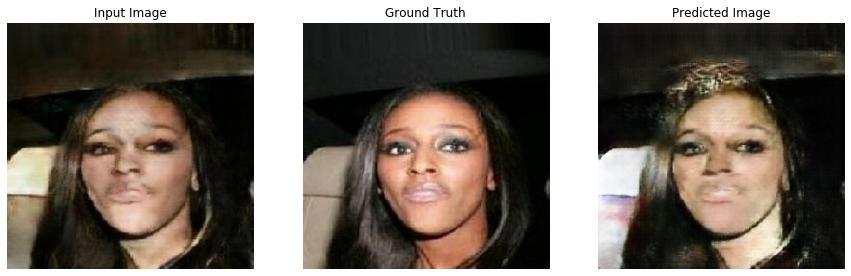

done


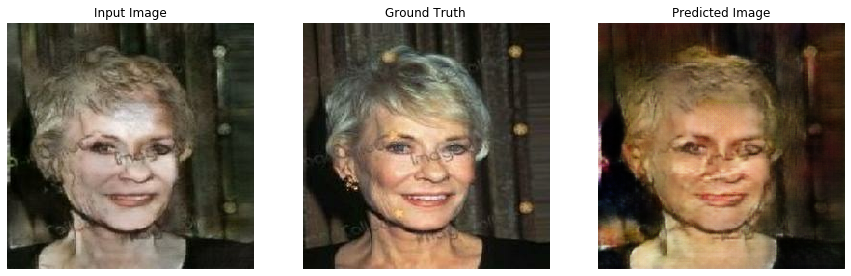

In [ ]:
# Run the trained model on the entire test dataset
from google.colab import files
for inp, tar in test_dataset.take(5):
  generate_images(generator, inp, tar)

In [ ]:
#!zip -r /content/training_checkpoints/*

In [ ]:
def save_images(model, test_input, tar, name):
  print( )
  prediction = model(test_input, training=True)
  plt.figure(1)
  #plt.title('Prediction')
  plt.axis('off')
  plt.imshow(prediction[0]*0.5+.5)
  plt.savefig("/content/Predicted/" + str(name) + ".jpg")
  
  plt.figure(2)
  #plt.title('Target')
  plt.axis('off')
  plt.imshow(tar[0]*0.5+0.5)
  plt.savefig("/content/Test/photo/" + str(name) + ".jpg")
  
  plt.figure(3)
  plt.axis('off')
  plt.imshow(test_input[0]*0.5+0.5)
  plt.savefig("/content/Test/sketch/" + str(name) + ".jpg")

In [ ]:
!rm -rf /content/Predicted/*
!rm -rf /content/Train/photo/*
!rm -rf /content/Train/sketch/*

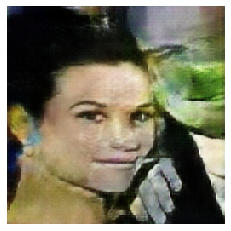

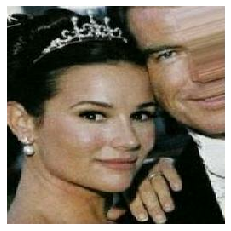

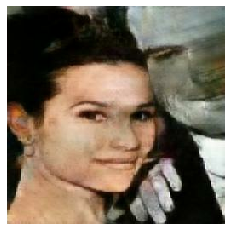

In [ ]:
i = 1000;
for input_image, target in test_dataset:
  name = i;
  i=i+1;
  save_images(generator, input_image, target, name)

In [ ]:
!zip -r '/content/Test.zip' '/content/Test/' 

  adding: content/Test/ (stored 0%)
  adding: content/Test/sketch/ (stored 0%)
  adding: content/Test/sketch/1116.jpg (deflated 6%)
  adding: content/Test/sketch/1129.jpg (deflated 7%)
  adding: content/Test/sketch/1178.jpg (deflated 5%)
  adding: content/Test/sketch/1015.jpg (deflated 6%)
  adding: content/Test/sketch/1115.jpg (deflated 9%)
  adding: content/Test/sketch/1162.jpg (deflated 6%)
  adding: content/Test/sketch/1057.jpg (deflated 6%)
  adding: content/Test/sketch/1099.jpg (deflated 6%)
  adding: content/Test/sketch/1108.jpg (deflated 6%)
  adding: content/Test/sketch/1122.jpg (deflated 6%)
  adding: content/Test/sketch/1156.jpg (deflated 7%)
  adding: content/Test/sketch/1168.jpg (deflated 6%)
  adding: content/Test/sketch/1056.jpg (deflated 6%)
  adding: content/Test/sketch/1021.jpg (deflated 6%)
  adding: content/Test/sketch/1047.jpg (deflated 6%)
  adding: content/Test/sketch/1130.jpg (deflated 5%)
  adding: content/Test/sketch/1030.jpg (deflated 6%)
  adding: content/Te

In [ ]:
!zip -r '/content/Predicted.zip' '/content/Predicted/' 

  adding: content/Predicted/ (stored 0%)
  adding: content/Predicted/1116.jpg (deflated 6%)
  adding: content/Predicted/1129.jpg (deflated 7%)
  adding: content/Predicted/1178.jpg (deflated 6%)
  adding: content/Predicted/1015.jpg (deflated 6%)
  adding: content/Predicted/1115.jpg (deflated 7%)
  adding: content/Predicted/1162.jpg (deflated 5%)
  adding: content/Predicted/1057.jpg (deflated 5%)
  adding: content/Predicted/1099.jpg (deflated 6%)
  adding: content/Predicted/1108.jpg (deflated 6%)
  adding: content/Predicted/1122.jpg (deflated 6%)
  adding: content/Predicted/1156.jpg (deflated 6%)
  adding: content/Predicted/1168.jpg (deflated 6%)
  adding: content/Predicted/1056.jpg (deflated 6%)
  adding: content/Predicted/1021.jpg (deflated 5%)
  adding: content/Predicted/1047.jpg (deflated 6%)
  adding: content/Predicted/1130.jpg (deflated 5%)
  adding: content/Predicted/1030.jpg (deflated 5%)
  adding: content/Predicted/1147.jpg (deflated 6%)
  adding: content/Predicted/1166.jpg (def

In [ ]:
#from google.colab import files
#files.download("/content/file.zip")